# Simple Self Contained Model of the Funcspec Project

In [1]:
import torch.nn as nn
import torch
import torch.nn.functional as F
from torchvision.datasets import EMNIST
import numpy as np
from tqdm.notebook import tqdm as tqdm_n
import matplotlib.pyplot as plt
import seaborn as sns
from torchviz import make_dot
from torchsummary import summary
from torch.utils.data import DataLoader
from copy import copy, deepcopy
from tqdm.notebook import tqdm, trange

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
col = ['xkcd:cloudy blue', 'xkcd:gray', 'xkcd:orange', 'xkcd:dark seafoam', 'xkcd:purple']


## Data

### Datasets

In [4]:
from community.data.datasets import get_datasets_symbols
from community.utils.plotting import plot_grid, create_gifs

In [5]:
use_cuda = True
device = torch.device("cuda" if use_cuda else "cpu")
batch_size = 256


In [6]:
n_classes = 50

data_config = {'data_size' : (30000, 5000),
                                'nb_steps' : 50,
                                'n_symbols' : n_classes - 1,
                                'symbol_type' : '0',
                                'input_size' : 50,
                                'static' : True, 
                                'double_data' : False                      
    }

if data_config['static'] : 
    data_config['nb_steps'] = 10
    data_config['data_size']  = [d*2 for d in data_config['data_size']]    

if not data_config['double_data'] : 
    n_classes //= 2

n_bits = np.ceil(np.log2(n_classes)).astype(int)
loaders, datasets = get_datasets_symbols(data_config, batch_size, use_cuda, plot=False)


Generating Data: 100%|██████████| 10000/10000 [00:00<00:00, 58730.26it/s]


## Tasks

In [7]:
def get_task_target(target, task) : 
    tasks = task.split('_')
    print(tasks)
    try :
        task = int(tasks[-1])
        target = target[:, task]
    except ValueError : 
        'continue'
    if 'parity' in tasks :
        target = parity_task(target)
    elif 'count' in tasks : 
        if 'max' in tasks : 
            target = symbol_count(target)
        elif 'equal' in tasks : 
            target = symbol_count(target) != 0
    elif 'nonzero' in tasks : 
        target = target > 0
    elif 'none' in tasks : 
        print(target.shape)
        target = target.T
        print(target.shape)
    else : 
        raise NotImplementedError

    return target.type(torch.LongTensor).to(target.device)

from community.data.tasks import get_task_target

def parity_task(target) : 

    parity = 1 - target.sum(-1)%2
    parity_target = torch.where(parity.bool(), target[:, 0], target[:, 1])
    return parity_target

def new_parity_task(target) : 
    parity = 1 - target.sum(-1)%2
    equal = (target[:, 0].eq(target[:, 1]))
    parity_target = torch.where(parity.bool(), target[:, 0], target[:, 1])
    parity_target = torch.where(equal, torch.full_like(parity_target, n_classes), parity_target)

    return parity_target

def process_data(data, flatten=True, device=device) : 

    if len(data.shape) == 5 :
         data =  data.permute(1, 2, 0, 3, 4)
    else : 
        data =  data.transpose(0, 1)
    if flatten : data = data.flatten(start_dim=-2) 
    else : 
        data = data.unsqueeze(-3)
    
    return data.float().to(device)
    
def get_data(task=None, flatten=True, device=device) : 
    data, target = next(iter(loaders[1]))
    print(data.shape)
    data = process_data(data, flatten=flatten)
    if task : target = get_task_target(target, task)

    return data, target.float().to(device)

def symbol_count(target) : 
    new_target = torch.where(target.argmax(-1).bool(), target[:, 1], target[:, 0])
    new_target[target[:, 0] == target[:, 1]] = 0
    return new_target


#### Stats

In [8]:
task = 'sum'
get_all_targets = lambda : torch.cat([t for _, t in loaders[1]])

if False : 
    
    all_targets = get_all_targets()
    uniques, unique_counts = all_targets.unique(dim=0, return_counts=True)
    task_t = get_task_target(all_targets, task)
    task_t.unique(dim=0, return_counts=True), (all_targets[:, 0] == task_t).unique(dim=0, return_counts=True), (all_targets[:, 1] == task_t).unique(dim=0, return_counts=True)
    digits_in = lambda d1, d2 : (torch.tensor([d1, d2]) == uniques).all(1).any()
    digits_idx = lambda d1, d2 : (torch.tensor([d1, d2]) == uniques).all(1).float().argmax()
    counts = np.zeros((n_classes+1, n_classes+1))
    targets = np.zeros((n_classes+1, n_classes+1), dtype=object)

    for d1 in range(n_classes) : 
        counts[d1, -1] = ((all_targets[:, 0] == task_t)[all_targets[:, 0] == d1]).sum() #unique_counts[(uniques == d1)[:, 0]].sum()
        targets[d1, -1] = str( counts[d1, -1])
        for d2 in range(n_classes) : 
            if digits_in(d1, d2) : 
                counts[d1, d2] = unique_counts[digits_idx(d1, d2)]
                targets[d1, d2] = f'{get_task_target(uniques, task)[digits_idx(d1, d2)].cpu().data.item()} | {unique_counts[digits_idx(d1, d2)]}'
            else : 
                counts[d1, d2] = -0.1
                targets[d1, d2] = 'X'
            counts[-1, d2] = ((all_targets[:, 1] == task_t)[all_targets[:, 1] == d2]).sum() #unique_counts[(uniques == d2)[:, 1]].sum()
            targets[-1, d2] = str( counts[-1, d2])

    counts[-1, -1] = unique_counts.sum().cpu().data.item()
    try : 
        d0_count =  (all_targets[:, 0] == task_t).unique(dim=0, return_counts=True)[1][1]
        print((all_targets[:, 0] == task_t).unique(dim=0, return_counts=True))
    except IndexError : 
        d0_count = 0
    try : 
        d1_count =  (all_targets[:, 1] == task_t).unique(dim=0, return_counts=True)[1][1]
    except IndexError : 
        d1_count = 0

    targets[-1, -1] = str(f'D0 : {d0_count} \n'
                    f'D1 : {d1_count}')
                
    plt.figure(figsize=(5, 5), dpi=150)
    ax = sns.heatmap(counts, cmap="inferno", annot=targets, annot_kws={'fontsize': 7}, fmt='s')
    ax.set_title('Number of examples and global targets')

    ax.set_xlabel('Digit received by Agent 1')
    ax.set_ylabel('Digit received by Agent 0')
    ax.set_xticklabels([str(i) for i in range(n_classes)] + ['dig=global'], fontsize=7)
    ax.set_yticklabels([str(i) for i in range(n_classes)] + ['dig=global'], fontsize=7)

    plt.show()

    #loaders, datasets = get_datasets_symbols(data_config, batch_size, use_cuda)
    all_targets = get_all_targets()
    task_t = get_task_target(all_targets, task)
    all_targets[:, 1].unique(return_counts=True), task_t.unique(return_counts=True)

#### Gifs

In [9]:
if True : 
    datasets[0].regenerate = False
    data, target = get_data(flatten=False)
    print(data.shape)
    create_gifs(data[:, 0, :,  0 , :, :], target[:, 0], 'symbols', data_config['input_size'], 'none', data_config['double_data'])

torch.Size([256, 10, 2, 50, 50])
torch.Size([10, 2, 256, 1, 50, 50])


## Models

In [10]:
class SmoothStep(torch.autograd.Function):
    '''
    Modified from: https://pytorch.org/tutorials/beginner/examples_autograd/two_layer_net_custom_function.html
    '''

    @staticmethod
    def forward(aux, x, thr=0):
        aux.save_for_backward(x)
        return (x >=thr).type(x.dtype)

    def backward(aux, grad_output):
        # grad_input = grad_output.clone()
        input, = aux.saved_tensors
        grad_input = grad_output.clone()
        grad_input[input <= -.5] = 0
        grad_input[input > .5] = 0
        return grad_input
    
smooth_step = SmoothStep().apply
sigmoid = nn.Sigmoid()

class SurrGradSpike(torch.autograd.Function):
    """
    Here we implement our spiking nonlinearity which also implements 
    the surrogate gradient. By subclassing torch.autograd.Function, 
    we will be able to use all of PyTorch's autograd functionality.
    Here we use the normalized negative part of a fast sigmoid 
    as this was done in Zenke & Ganguli (2018).
    """
    
    scale = 100.0 # controls steepness of surrogate gradient

    @staticmethod
    def forward(ctx, input, thr=0):
        """
        In the forward pass we compute a step function of the input Tensor
        and return it. ctx is a context object that we use to stash information which 
        we need to later backpropagate our error signals. To achieve this we use the 
        ctx.save_for_backward method.
        """
        ctx.save_for_backward(input)
        out = -torch.ones_like(input)
        out[input > thr] = 1.0
        return out

    @staticmethod
    def backward(ctx, grad_output):
        """
        In the backward pass we receive a Tensor we need to compute the 
        surrogate gradient of the loss with respect to the input. 
        Here we use the normalized negative part of a fast sigmoid 
        as this was done in Zenke & Ganguli (2018).
        """
        input, = ctx.saved_tensors
        grad_input = grad_output.clone()
        grad = grad_input/(SurrGradSpike.scale*torch.abs(input)+1.0)**2
        return grad
    
# here we overwrite our naive spike function by the "SurrGradSpike" nonlinearity which implements a surrogate gradient
super_spike  = SurrGradSpike.apply

In [11]:
def get_padding(S, K, W) : 
    return int(((S-1)*W-S+K)/2)

def init_weights(net, scale) : 
    for n, p in net.named_parameters() : 
        try : 
            torch.nn.init.xavier_normal_(p)
        except ValueError : 
            'continue'
        p.data *= scale

class Agent(nn.Module) : 

    def __init__(self, dims, use_conv=False, use_bottleneck=False, dropout=0., w_scale=1., n_layers=1, dual_readout=False) : 
        super().__init__()
        self.dims = dims
        if use_conv : 
            #K, S, W = 3, 1, data_config['input_size'] 
            #P = get_padding(S, K, W)
            convs = []
            channels = [1, 4]
            kernels = [5, 3]
            pools = [2, 2]
            feature_height, feature_width = [data_config['input_size']] * 2
            for i, (K, P, n_in, n_out) in enumerate(zip(kernels, pools, channels[:-1], channels[1:])) :
                
                convs.append(nn.Conv2d(n_in, n_out, K, 1, padding='same'))
                convs.append(nn.MaxPool2d(P))
                convs.append(nn.ReLU())
                if dropout > 0. : 
                    convs.append(nn.Dropout(dropout))

            convs.append(nn.Flatten())
            self.conv = nn.Sequential(*convs)
            
            #self.conv = nn.Sequential(nn.Conv2d(1, 8, K, S, P), nn.Flatten())

            dummy_data = torch.zeros([1] + [channels[0]]+ [data_config['input_size']] * 2) 
            dummy_out = self.conv(dummy_data)
            print(dummy_out.shape)
            self.dims[0] = dummy_out.shape[-1]
        else : 
            self.conv = None

        self.use_bottleneck = use_bottleneck
        self.n_layers = n_layers
        if data_config['static'] : 
            self.cell = nn.RNN(dims[0], dims[1], n_layers, bias=False, batch_first=False)
        else : 
            self.cell = nn.GRU(dims[0], dims[1], n_layers, bias=False, batch_first=False)

        self.dropout = nn.Dropout(dropout) if dropout > 0 else None

        n_in_readout = dims[1]
 
        if use_bottleneck :  
            n_bot = 5
            self.bottleneck = nn.Sequential(nn.Linear(n_in_readout, n_bot, bias=False), nn.ReLU()) 
            self.bottleneck.out_features = n_bot
            self.readout = nn.Sequential(nn.Linear(n_bot, dims[-1], bias=False), nn.Softmax())
        else :
            #self.readout = nn.Sequential(nn.Linear(n_in_readout, dims[-1], bias=False), nn.Softmax())
            self.readout = nn.Linear(n_in_readout, dims[-1], bias=False)

        self.dual_readout = dual_readout
        if dual_readout : 
            self.readout2 = deepcopy(self.readout)

        init_weights(self, w_scale)

        #self.readout = nn.Linear(dims[1], dims[2], bias=False)

    def forward(self, input, state=None, connections=0) : 

        if self.conv : 
            input = self.conv(input)

        if len(input.shape ) < 3 : 
            input = input.unsqueeze(0)

        if state is None : 
            out, h = self.cell(input)
        else : 
            if self.n_layers > 1 : 
                h = torch.stack([state[0] + connections, *state[1:]])
            else : 
                h = state + connections
            out, h = self.cell(input, h)

        if self.dropout : 
            out = self.dropout(out)

        if self.use_bottleneck : 
            out = self.bottleneck(out[0]).unsqueeze(0)

        if self.dual_readout : 
            out1, out2 = self.readout(out[0]), self.readout2(out[0])
            out = torch.stack([out1, out2])
        else : 
            out = self.readout(out[0])

        return out, h

class Connection(nn.Linear) : 

    def __init__(self, dims, p, binarize=False, w_scale=1.) : 

        super().__init__(dims[0], dims[1], bias=False)

        init_weights(self, w_scale)

        self.sparsity = p
        n_in, n_out = dims
        self.nb_non_zero = int(p*n_in*n_out)

        w_mask = self.init_mask(n_in, n_out)
        
        self.register_buffer('w_mask', w_mask)
        self.binarize = binarize
        
        assert w_mask.sum() == self.nb_non_zero, f'Number of nonzero connection is {w_mask.sum()}, expected {self.nb_non_zero}'

    def init_mask(self, n_in, n_out) : 
        w_mask = np.zeros((n_in, n_out), dtype=bool)
        ind_in, ind_out = np.unravel_index(np.random.choice(np.arange(n_in*n_out), self.nb_non_zero, replace=False), (n_in, n_out))
        if (len(np.unique(ind_in)) == 1 or len(np.unique(ind_in)) == 1)  and self.nb_non_zero > 1: 
            return self.init_mask(n_in, n_out)
        else  : 
            print(ind_in, ind_out)
            w_mask[ind_in, ind_out] = True
            w_mask = torch.tensor(w_mask)
            return w_mask


    def forward(self, input) : 
        out = F.linear(input, self.weight*self.w_mask)
        if self.nb_non_zero > 0 : 
            assert ((out != 0).float().sum(-1).max() <= self.nb_non_zero), f'{(out != 0).float().sum(-1).max()} non zero connections, expected {self.nb_non_zero} !'
        if self.binarize  : 
            out = super_spike(out)
        return out
        
def binary_conn(target, ag) : 
    encoding = []
    encoded_target = target[:, ag].clone().detach()
    for d in range(n_bits-1, -1, -1) : 
        encoding.append(torch.div(encoded_target, 2**d, rounding_mode='floor'))
        encoded_target -= torch.div(encoded_target, 2**d, rounding_mode='floor')*2**d
    return torch.stack(encoding, -1)


class DroupoutMasked(nn.Dropout) : 
    #Dropout mask that can't put nonzero connections at zero
    def __init__(self, conn_mask, p: float = 0.5, inplace: bool = False) -> None:
        super().__init__(p, inplace)
        
        #True where connections are nonzero else False
        self.register_buffer('conn_mask', conn_mask)

    def forward(self, x) : 
        x_temp = super().forward(x)

        conn_mask = self.conn_mask.expand_as(x_temp)
                
        #Final dropout mask, True where not dropped or connections are nonzero
        mask = (x_temp != 0) | (conn_mask)

        return x * mask

class Ensemble(nn.Module) : 
    def __init__(self, dims, p, use_conv=False, binary_con=False,
                 use_bottleneck=False, dual_readout=False, common_readout=False,
                 dropout=0., w_scale=.1,
                 n_layers=1) : 

        super().__init__()
        self.n_in, self.n_hid, self.n_out = dims
        self.n_layers = n_layers
        self.connections = nn.ModuleList([Connection([dims[1]]*2, p, binary_con, w_scale) for _ in range(2)])
        
        self.conn_masks = [c.w_mask for c in self.connections]
        
        self.nonzero_received = [torch.where(c)[0] for c in self.conn_masks][::-1]
        self.nonzero_sent = [torch.where(c)[1] for c in self.conn_masks]

        self.agents = nn.ModuleList([Agent(dims, use_conv, use_bottleneck, dropout, w_scale, n_layers, dual_readout[0]) for i in range(2)])[::-1]
        self.is_community = True

        self.use_common_readout = common_readout
        self.dual_readout = dual_readout[1]
        if common_readout : 
            self.common_readout = nn.Linear(2*dims[-2], dims[-1])
            if self.dual_readout : 
                self.common_readouts = nn.ModuleList([self.common_readout, deepcopy(self.common_readout)])
        else : 
            self.common_readout = None

    def forward(self, input, forced_conns=None): 

        t_min = data_config['nb_steps'] // 2

        states, conns = [[None] for _ in range(2)], [[] for _ in range(2)]
        outputs = [[] for _ in range(2)] if not self.use_common_readout else []
        
        for t, t_input in enumerate(input) :
            for ag, agent in enumerate(self.agents) : 
                
                ag_input = t_input[ag]
                
                if t >= t_min: 
                    if forced_conns is not None: 
                        input_connect = forced_conns[:, ag]
                    else : 
                        input_connect = self.connections[1-ag](states[1-ag][-1][-1])
                else : 
                    input_connect = 0                
                
                out, h = agent(ag_input, states[ag][-1], input_connect)    
                
                states[ag].append(h)
                if not self.use_common_readout : outputs[ag].append(out)
                conns[ag].append(input_connect)

            if self.use_common_readout : 
                if self.dual_readout : 
                    out = torch.stack([r(torch.cat([s[-1] for s in states], -1))[0] for r in self.common_readouts])
                else:
                    out = self.common_readout(torch.cat([s[-1] for s in states], -1) )
                outputs.append(out)

        if not self.use_common_readout : 
            outputs = torch.stack([torch.stack(o) for o in outputs], 1)
        else : 
            outputs = torch.stack(outputs, 0)
            
        if self.n_layers > 1 : 
            states = torch.stack([torch.stack([s[-1] for s in st[1:]]) for st in states], 1)
        else  :
            states = torch.stack([torch.stack(s[1:]) for s in states], 1)
        conns = torch.stack([torch.stack(c[t_min:]) for c in conns], 1)
        
        #print((outputs[-1][1] == outputs[-1][1]).all())

        return outputs, states, conns
     

## Decisions


In [12]:
def get_decision(outputs, decision_params, target=None) : 
    temporal_decision, agent_decision = decision_params

    if temporal_decision == 'last' : 
        outputs = outputs[-1]
    elif temporal_decision == 'sum' : 
        outputs = outputs.sum(0)
    else : 
        raise NotImplementedError
    agent_decisions = agent_decision.split('_')
    
    try : 
        deciding_ags = int(agent_decisions[-1])
        outputs = outputs[deciding_ags]
        deciding_ags = torch.ones(outputs.shape[0])*deciding_ags
        return outputs, deciding_ags

    except ValueError : 
        
        if agent_decision == 'max' : 
            device = outputs.device
            n_agents = outputs.shape[0]
            max_out = lambda i : torch.max(outputs[i,...], axis=-1)
            _, deciding_ags = torch.max(torch.stack([max_out(i)[0] for i in range(n_agents)]), axis=0)
            mask_1 = deciding_ags.unsqueeze(0).unsqueeze(-1).expand_as(outputs)
            mask_2 = torch.einsum('b, bcx -> bcx', torch.arange(n_agents).to(device), torch.ones_like(outputs))
            mask = (mask_1 == mask_2)

            return (outputs*mask).sum(0), deciding_ags
            
        elif agent_decision == 'both' : 
            return outputs, None

        elif 'sum' in agent_decision : 
            return outputs.sum(0), None
        else : 
            raise NotImplementedError

from community.common.decision import get_decision

def check_grad(model, task_id = '0') : 
    for n, p in model.named_parameters() : 
        if 'k_params' in n or 'all_scores' in n : 
            if task_id in n : 
                return check_ind_grad(n, p)
        else : 
            check_ind_grad(n, p)

def check_ind_grad(n, p) : 
    if p.grad is not None : 
        if (p.grad == 0).all() : 
            ''
            print(f'{n}, Zero Grad')
        #else : print(f'{n} : {p.grad}')
    elif p.requires_grad : 
        ''
        print(f'{n}, None Grad')

## Init

In [13]:
task = 'both'
decision_params = ('last', 'both') # Change to '0', '1' or 'loss'

dims = [data_config['input_size']**2, 10, n_classes if not (task=='equal_count' or task=='nonzero') else 2]
sparsity =  0* 1/dims[1]**2

use_conv = False
binary_connections = False
use_bottleneck = False

dual_readout = [False, False]
common_readout = True

dual_readout[0] = (task in ['none', 'both'] and decision_params[1] == '0' ) or (task == decision_params[1] == 'both')
if task == 'both' and common_readout : 
    dual_readout[1] = True
    dual_readout[0] = False

community = Ensemble(dims, sparsity, use_conv, binary_connections, use_bottleneck, dual_readout, common_readout, n_layers=1,).to(device)

optimizer = torch.optim.Adam(community.parameters(), lr=1e-3)

gamma = 0.95 #** (1/len(loaders[0]))
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1, gamma, verbose=False)
#if use_conv :
    #summary(community.agents[0].conv, (1, data_config['input_size'], data_config['input_size']) if use_conv else (1, data_config['input_size']**2))

summary(community.agents[0], (1, data_config['input_size'], data_config['input_size']) if use_conv else (1, data_config['input_size']**2))

#plot_confusion_mat(community)
data, target = get_data(flatten=not use_conv, device=device)
#print(community)
#print(data.shape)

out, states, fconns = community(data)
if binary_connections : print(fconns[-1].unique(return_counts=True))
print(out.shape)
#symbol_count(target).unique(return_counts=True), (symbol_count(target) == target[:, 0]).unique(return_counts=True)

[] []
[] []
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
               RNN-1  [[-1, 1, 10], [-1, 1, 10]]               0
            Linear-2                   [-1, 25]             250
Total params: 250
Trainable params: 250
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.01
----------------------------------------------------------------
torch.Size([256, 10, 2, 50, 50])
torch.Size([10, 2, 256, 25])


In [15]:
file_path = f'saves/network_{n_classes}{"_non"*(1 - data_config["static"])}_static_p={sparsity}'
#torch.save(community.state_dict(), file_path)
#community.load_state_dict(torch.load(file_path))

In [ ]:
#Stop exec before training
raise StopIteration

StopIteration: 

In [ ]:
task = 'max_count'

## Training

In [ ]:
n_epochs = 50

pbar = tqdm_n(range(n_epochs))
descs = np.full((2), '', dtype=object)

check_gradients = False
train, test = True, True
early_stop = True
test_cheat = False

force_connections = False

best_acc = 0
acc_hist, loss_hist = [[] for _ in range(2)], [[] for _ in range(2)]

def get_loss(output, t_target) : 
    n_target = len(t_target.shape)
    n_decisions = output.shape[:-2]

    if len(n_decisions) == 1 : 
        n_decisions = n_decisions[0]
    elif len(n_decisions) == 0 : 
        n_decisions = 1

    if n_target == n_decisions == 1 : 
        loss = F.cross_entropy(output, t_target, reduction='none')
        output = output.unsqueeze(0)

    elif n_target == 1  and n_decisions != 1: 
        t_target = t_target.unsqueeze(0).expand(output.shape[:-1])
        loss = torch.stack([F.cross_entropy(o, t, reduction='none') for o, t in zip(output, t_target)]).T

    elif n_target != 1  and n_decisions == 1: 
        loss = torch.stack([F.cross_entropy(output, t, reduction='none') for t in t_target]).T
    
    elif n_target == n_decisions : 
        loss = torch.stack([F.cross_entropy(o, t, reduction='none') for o, t in zip(output, t_target)]).T

    else : 
        res = [get_loss(o, t_target) for o in output]
        loss, t_target = torch.stack([r[0] for r in res]).T, torch.stack([r[1] for r in res])

    return loss.mean(), t_target, output


for epoch in pbar : 
    train_loader, test_loader = loaders

    if train : 
            
        # Training
        losses, accs = [], []
        for batch_idx, (data, target) in enumerate(train_loader) : 
            
            data = process_data(data, not use_conv, device)
            t_target, target = get_task_target(target, task).to(device), target.to(device)
            
            if test_cheat : 
                data[:, 0] = data[:, 1]

            optimizer.zero_grad()

            if force_connections : 
                conns = fconns[-1].detach().unsqueeze(0)
                for ag in range(2) : 
                    conns[:, ag, :, community.nonzero_received[ag]] = binary_conn(target, 1-ag).float()
                conns[conns == 0] = -1
            else : 
                conns=None

            outputs, states, conns = community(data, conns)
            #print((outputs[-1][0] == outputs[-1][1]).all())

            output, deciding_ags = get_decision(outputs, *decision_params)

            loss, t_target, output = get_loss(output, t_target)
            #t_masks = [(target == t ).all(1) for t in target.unique(dim=0)]
            #t_masks = [(target == t).any(1)]
            #masks = [(t_target == 0)*t_masks[0], (t_target == 3)*t_masks[0]]
            #factors = torch.ones(len(t_masks))
            #factors[0] *= 1
            #loss = torch.stack([loss[m].mean()*f for m, f in zip(t_masks, factors)]).mean()

            loss.backward()
            losses.append(loss.cpu().data.item())

            if check_gradients : 
                zero_grads = np.array([((p.grad == 0).all()).cpu().data.item() for p in community.parameters() if p.grad is not None])
                none_grads = np.array([p.grad is None for p in community.parameters()])
                zero_params = np.array(list(dict(community.named_parameters()).keys()), dtype=object)[~none_grads][zero_grads]
                none_params = np.array(list(dict(community.named_parameters()).keys()), dtype=object)[none_grads]

                print(f'Zero params : {zero_params}')
                print(f'None Params : {none_params}')
                
            optimizer.step()#, scheduler.step()

            pred = output.argmax(dim=-1)
            correct = pred.eq(t_target.view_as(pred))
            acc = (correct.sum(-1)*np.prod(t_target.shape[:-1]) / t_target.numel()).cpu().data.numpy()
        
            #acc = [(correct[m].sum()/m.sum()).cpu().data.numpy() for m in masks]

            accs.append(acc)

            descs[0] = str('Train Epoch: {} [{}/{} ({:.0f}%)] Loss: {:.3f}, Accuracy: {}%, Decider : {}'.format(
                            epoch, batch_idx  * batch_size, len(train_loader.dataset),
                            100. * batch_idx / len(train_loader), loss.item(),
                            ([np.round(100*a) for a in acc]) if type(acc) is list else np.round(100*acc), 
                            np.round(deciding_ags.float().mean().cpu().data.item(), 1) if deciding_ags is not None else 'none')
                            )

            pbar.set_description((descs.sum()))
        
        loss_hist[0].append(np.mean(losses))
        acc_hist[0].append(np.mean(accs))

    if test : 
        losses, accs = [], []
        for batch_idx, (data, target) in enumerate(test_loader) : 
            
            data, target = process_data(data, not use_conv, device), target.to(device)
            if test_cheat : 
                data[:, 0] = data[:, 1]
            t_target = get_task_target(target, task).to(device)

            if force_connections : 
                conns = fconns[-1].clone().detach().unsqueeze(0)
                for ag in range(2) :   
                    conns[:, ag, :, community.nonzero_received[ag]] = binary_conn(target, 1-ag).float()
                conns[conns == 0] = -1
            else : 
                conns=None

            outputs, states, _ = community(data, conns)
            #print((outputs[-1][0] == outputs[-1][1]).all())
            output, deciding_ags = get_decision(outputs, *decision_params, t_target)

            loss, t_target, output = get_loss(output, t_target)
            loss = loss.mean()
            losses.append(loss.cpu().data.item())

            pred = output.argmax(dim=-1, keepdim=True)
            correct = pred.eq(t_target.view_as(pred)).sum().cpu().data.item()
            accs.append(correct / t_target.numel())

        acc = np.mean(accs)

        loss_hist[1].append(np.mean(losses))
        acc_hist[1].append(np.mean(accs))
        
        descs[1] = str('| Test : Loss: {:.3f}, Accuracy: {}%'.format(
                        loss.item(),
                        (np.round(100*a) for a in acc) if type(acc) is list else np.round(100*acc))
                        )

        pbar.set_description((descs.sum()))

    scheduler.step()
    
    if acc > best_acc : 
        best_model = deepcopy(community)
        best_acc = acc
        
    if acc > 0.95 and early_stop: 
        break

decision_params = ('last', 'both') # Change to '0', '1' or 'loss'


  0%|          | 0/50 [00:00<?, ?it/s]

## Results

### Metrics

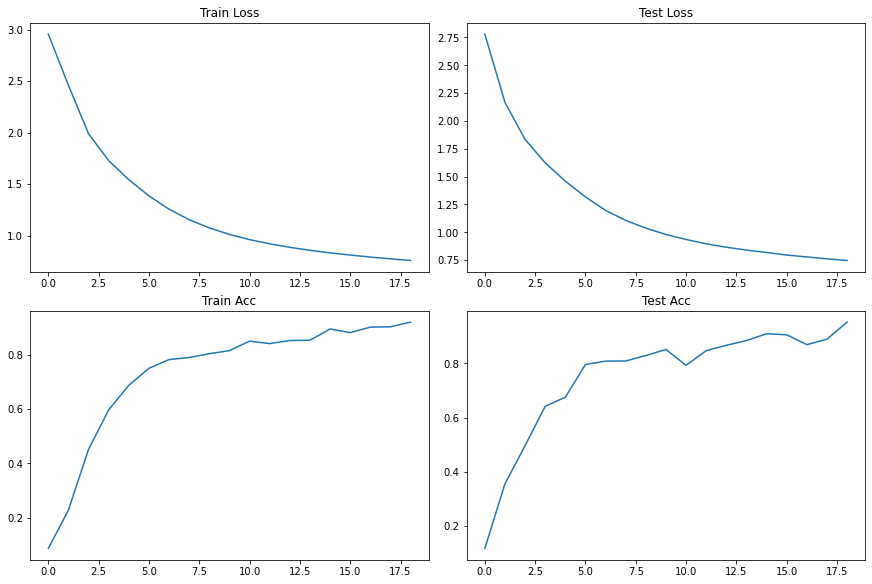

In [ ]:
fig, axs = plt.subplots(2, 2, constrained_layout=True, figsize=(12, 8)) 
for metric, m_axs, m_name in zip([loss_hist, acc_hist], axs, ['Loss', 'Acc']) : 
    for trial, ax, t_name in zip([0, 1], m_axs, ['Train', 'Test']) : 
        ax.plot(metric[trial])
        ax.set_title(f'{t_name} {m_name}')

In [ ]:
#torch.save(best_model.state_dict(), f'saves/network_{task}_{n_classes}{"_non"*(1 - data_config["static"])}_static_p={sparsity}') 

### Accuracy Matrix

/home/gb21/.conda/envs/community/lib/python3.10/site-packages/torch/nn/modules/rnn.py:471: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at  /opt/conda/conda-bld/pytorch_1646755897462/work/aten/src/ATen/native/cudnn/RNN.cpp:926.)
  result = _VF.rnn_tanh(input, hx, self._flat_weights, self.bias, self.num_layers,


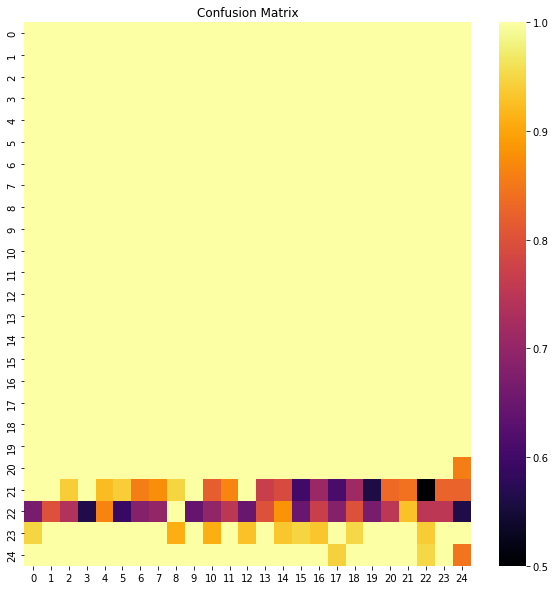

In [ ]:
decision_params = ('last', '0')
def plot_accuracy_matrix(model, test_loader) : 

    accs = []
    targets, t_targets = [], []
    fig, ax = plt.subplots(1, 1, figsize = (10, 10))
    for batch_idx, (data, target) in enumerate(test_loader) : 
        
        data, target = process_data(data, not use_conv, device), target.to(device)
        t_target = get_task_target(target, task).to(device)

        if force_connections : 
            conns = fconns.clone().detach()
            for ag in range(2) :   
                conns[:, ag, :, community.nonzero_received[ag]] = binary_conn(target, 1-ag)
            conns[conns == 0] = -1
        else : 
            conns=None

        outputs, states, conns = model(data, conns)
        #print((outputs[-1][0] == outputs[-1][1]).all())
        output, deciding_ags = get_decision(outputs, *decision_params, target)

        loss, t_target = get_loss(output, t_target, task)

        pred = output.argmax(dim=-1, keepdim=True)
        correct = pred.eq(t_target.view_as(pred)).cpu().data
        targets.append(target.cpu())
        t_targets.append(t_target.cpu())
        accs.append(correct)

    accs, targets = torch.cat(accs), torch.cat(targets)
    n_classes = len(targets.unique())
    t_masks = [(targets == t ).all(1) for t in targets.unique(dim=0)]
    acc_per_target = np.array([accs[m].float().mean() for m in t_masks]).reshape(n_classes, n_classes)
    
    #acc_per_target = np.array([[acc_per_target[t1*n_classes + t2].cpu().data.item() for t1 in range(n_classes)] for t2 in range(n_classes)])

    ax = sns.heatmap(acc_per_target, cmap="inferno", annot=None, annot_kws={'fontsize': 10}, fmt='s')
    ax.set_title('Confusion Matrix')   
    plt.show()

plot_accuracy_matrix(best_model, test_loader)

### Confusion Matrix

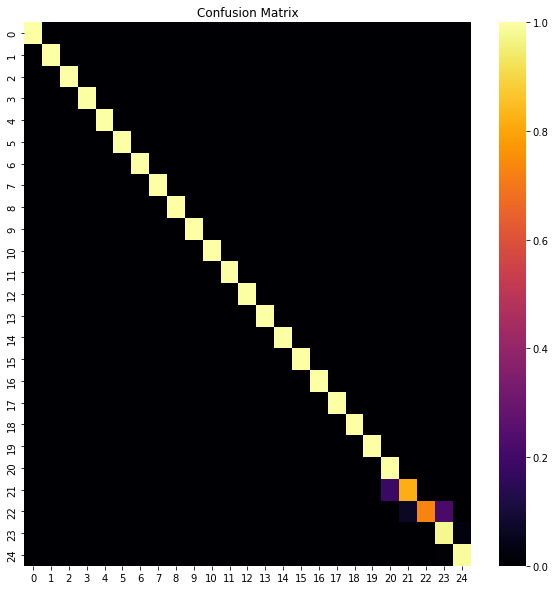

In [ ]:
def plot_confusion_mat(model, test_loader) : 

    accs, preds = [], []
    targets, t_targets = [], []
    fig, ax = plt.subplots(1, 1, figsize = (10, 10))
    for batch_idx, (data, target) in enumerate(test_loader) : 
        
        data, target = process_data(data, not use_conv, device), target.to(device)
        t_target = get_task_target(target, task).to(device)

        outputs, states, conns = model(data)
        #print((outputs[-1][0] == outputs[-1][1]).all())
        output, deciding_ags = get_decision(outputs, *decision_params, target)

        loss, t_target = get_loss(output, t_target, task)
        pred = output.argmax(dim=-1, keepdim=True)
        
        correct = pred.eq(t_target.view_as(pred)).cpu().data
        targets.append(target.cpu())
        t_targets.append(t_target.cpu())
        accs.append(correct)
        preds.append(pred.cpu())

    preds, t_targets = torch.cat(preds), torch.cat(t_targets)
    
    n_classes = len(t_targets.unique())
    t_masks = [(t_targets == t ) for t in t_targets.unique()]

    pred_per_target = [preds[m] for m in t_masks]
    n_pred_per_target = np.zeros((n_classes, n_classes))
    for t, p in enumerate(pred_per_target): 
        for (u, c) in zip(*p.unique(return_counts=True)) : 
            n_pred_per_target[t, u] = c

    n_pred_per_target /= n_pred_per_target.sum(1)
    
    #acc_per_target = np.array([[acc_per_target[t1*n_classes + t2].cpu().data.item() for t1 in range(n_classes)] for t2 in range(n_classes)])

    ax = sns.heatmap(n_pred_per_target, cmap="inferno", annot_kws={'fontsize': 10}, fmt='s')
    ax.set_title('Confusion Matrix')   
    plt.show()

    return n_pred_per_target

n_pred_per_target = plot_confusion_mat(best_model, test_loader)

## Analysis

### Connections

torch.Size([256, 10, 2, 50, 50])


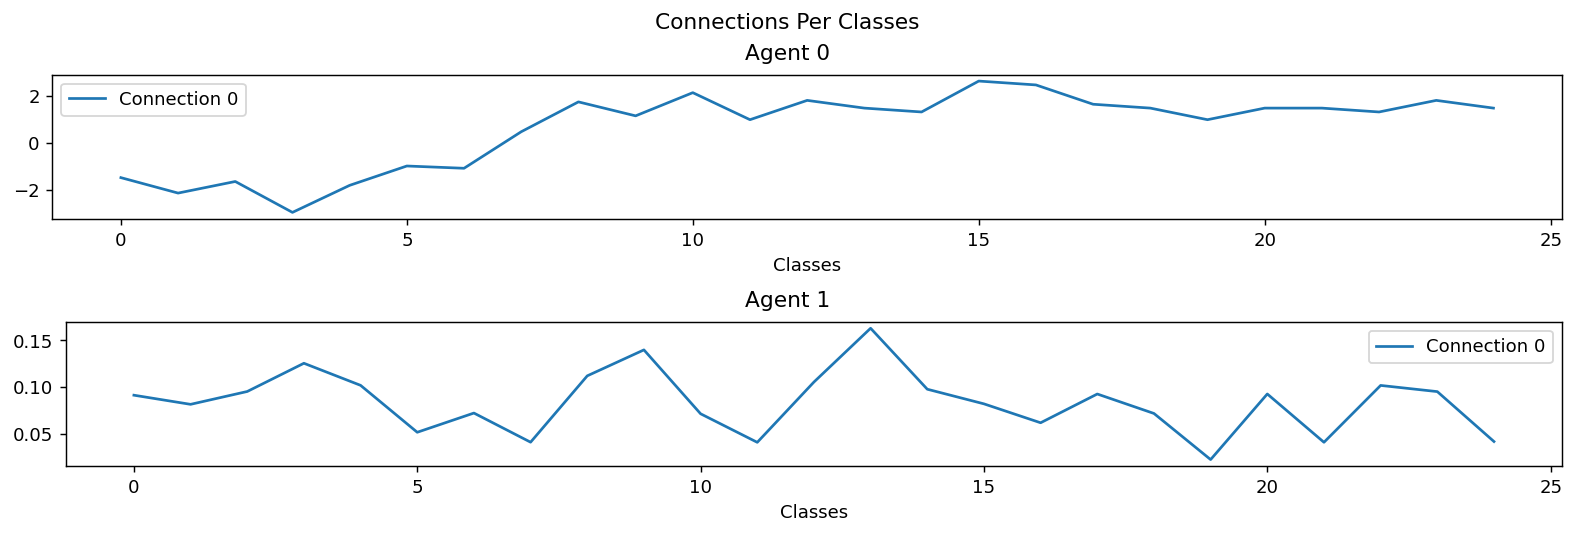

In [ ]:
community = best_model
community.to(device)
nonzero_idxs = community.nonzero_received
n_conns = len(nonzero_idxs[0])

#for data, target in loaders[1] : 
data, target = get_data(flatten = not use_conv)
    
#data, target = process_data(data, True, True, device), target.to(device)
out, states, conns = best_model(data.to(device))

if force_connections : 
    conns = -torch.ones_like(conns).to(device)
    for ag in range(2) : 
        conns[:, ag, :, community.nonzero_received[ag][:n_bits]] = binary_conn(target, 1-ag, n_classes)
        
    conns[conns == 0] = -1
    
#conns[-1][0].count_nonzero(dim=0)
#torch.stack([conns[-1][i].count_nonzero(dim=0).max() for i in range(2)])
#sums.append(torch.tensor([[conns[-1][i][target[:, i] == t].sum() for t in range(4)] for i in range(2)]))

"""
ncols = int(np.sqrt(n_conns))
nrows = n_conns // ncols
if ncols * nrows < n_conns : 
    ncols += 1
print(nrows, ncols)
"""

if data_config['static'] :

    sums = torch.tensor([[conns[-1, ag, target[:, 1-ag] == t][:, nonzero_idxs[ag]].sum(0) for t in range(n_classes)] for ag in range(2)])
    if n_conns == 1 : sums = sums.unsqueeze(-1)

    if n_classes < 4 : 

        nrows, ncols = 2, n_classes

        fig, axs = plt.subplots(nrows, ncols, figsize=(n_classes*(n_conns), 2), constrained_layout=True, dpi=100, sharey=True)

        for ag, ag_axs in enumerate(axs) : 
            for dig, ax in enumerate(ag_axs) : 
                sum = sums[ag][dig].cpu().data.numpy()
                bars = ax.bar(np.arange(len(sum)), sum, color=col)
                #ax.set_xticks(np.arange(len(sum)))
                #ax.bar_label(bars)
                #sns.heatmap(sum, cmap="inferno", annot=sum.round(1).astype(str), annot_kws={'fontsize': 16}, fmt='s', ax=ax)
                
                ax.set_xticks([])
                ax.set_xlabel(f'Digit {dig}')
                if dig == 0 : ax.set_ylabel(f'Ag {ag}')
    else : 
        lines = ['-', '--']
        fig = plt.figure(constrained_layout=True, figsize=(12, 4), dpi=130)
        fig.suptitle('Connections Per Classes')
        subfigs = fig.subfigures(nrows=2, ncols=1)
        nrows, ncols = 1, 1

        for ag, subfig in enumerate(subfigs) : 
            subfig.suptitle(f'Agent {ag}')
            sum = sums[ag]
            ax = subfig.subplots(nrows=nrows, ncols=ncols)

            [ax.plot(range(len(s)), s.cpu().data.numpy(), linestyle=lines[c%2], label=f'Connection {c}') for c, s in enumerate(sum.T)]
            ax.set_xlabel('Classes')
            ax.legend()
            #ax.set_title(f'Agent {i}')
            
else : 
    nrows, ncols = 1, 1

    lines = ['-', '--']
    fig = plt.figure(constrained_layout=True, figsize=(12, 4), dpi=130)
    fig.suptitle('Connections Through Time')
    subfigs = fig.subfigures(nrows=2, ncols=1)

    sums = torch.stack([torch.stack([community.nonzero_receivedonns[:, i, target[:, 1-i] == t][..., nonzero_idxs[1-i]].sum(1) for t in range(n_classes)]) for i in range(2)])
    for ag, subfig in enumerate(subfigs) : 
        subfig.suptitle(f'Agent {ag}')

        axs = subfig.subplots(nrows=nrows, ncols=ncols)
        if n_conns == 1 : 
            axs = np.array([axs])
        for i, ax in enumerate(axs.flatten()) : 
            sum = sums.cpu().data.numpy()[ag, ..., i]
            for t, s in enumerate(sum) : 
                ax.plot(range(len(s)), s, label=f'Digit {t}', linestyle=lines[t%2])

            ax.legend()
            ax.set_title(f'Connection {i}')

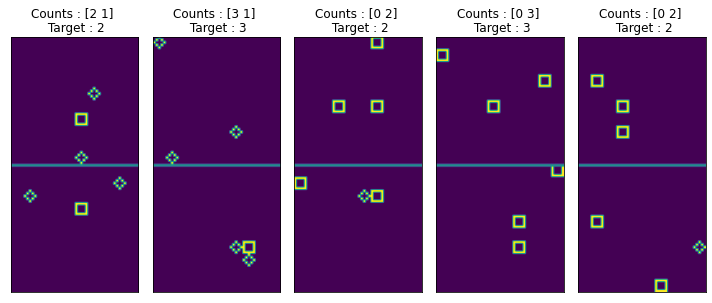

In [ ]:
data, target = next(iter(loaders[1]))
plot_data = data[:5, -1, :].reshape(-1, 1, 100, 50).cpu().data
t_target = get_task_target(target, task)
plot_data[..., 50, :] = .5
plot_grid(plot_data, [f'Counts : {t.data.numpy()} \n Target : {t_t.item()}' for t, t_t in zip(target, t_target)], figsize=(10, 10))

### Decisions

/tmp/ipykernel_58305/2224769916.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask = target.eq(torch.tensor(t)).all(axis=1)


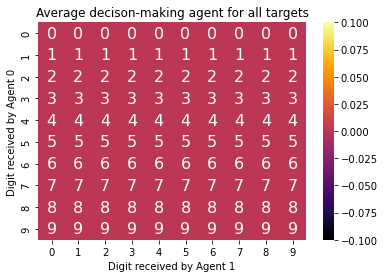

In [ ]:
get_all_targets = lambda : torch.cat([t for _, t in loaders[1]])

all_targets = get_all_targets()

uniques = all_targets.unique(dim=0).cpu()
decision_means = torch.zeros(len(uniques))

community.to('cpu')

for b_idx, (data, target) in enumerate(loaders[1]) : 
    
    data, target = process_data(data, True, True, 'cpu'), target.to('cpu')
    t_target = get_task_target(target, task).cpu()
    output, *_ = community(data)
    output, decision_ags = get_decision(output, decision_params, target=t_target)

    for i, t in enumerate(uniques) :             
        mask = target.eq(torch.tensor(t)).all(axis=1)
        if mask.sum() != 0 : 
            decision_means[i] += decision_ags[mask].float().cpu().sum()/mask.sum()

decision_means /= b_idx +1

digits_in = lambda d1, d2 : (torch.tensor([d1, d2]) == uniques).all(1).any()
digits_idx = lambda d1, d2 : (torch.tensor([d1, d2]) == uniques).all(1).float().argmax()
decisions = np.zeros((n_classes, n_classes))
targets = np.zeros((n_classes, n_classes), dtype=object)

for d1 in range(n_classes) : 
    for d2 in range(n_classes) : 
        if digits_in(d1, d2) : 
            decisions[d1, d2] = decision_means[digits_idx(d1, d2)]
            targets[d1, d2] = str(get_task_target(uniques, task)[digits_idx(d1, d2)].cpu().data.item())
        else : 
            decisions[d1, d2] = -0.1
            targets[d1, d2] = 'X'
            
ax = sns.heatmap(decisions, cmap="inferno", annot=targets, annot_kws={'fontsize': 16}, fmt='s')
ax.set_title('Average decison-making agent for all targets')

ax.set_xlabel('Digit received by Agent 1')
ax.set_ylabel('Digit received by Agent 0')

plt.show()

community.to(device);                                                                                     

### Conv Filters

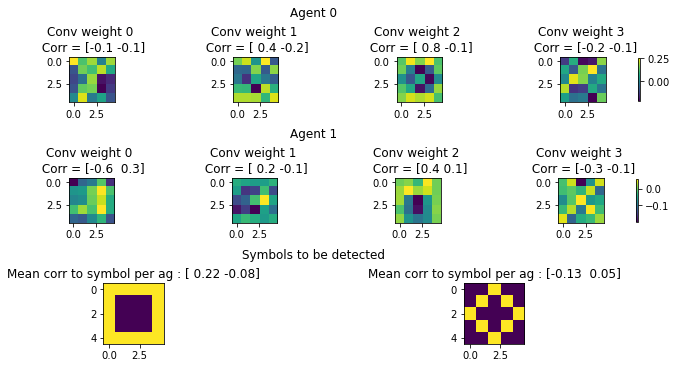

In [ ]:
from scipy.stats import pearsonr
if use_conv : 

    convs = [[c for c in ag.conv if type(c) is torch.nn.Conv2d] for ag in community.agents]
    symbols = datasets[0].symbols[:-1]

    corrs = np.array([[[pearsonr(kernel.cpu().data.numpy().flatten(), symbol.flatten() )[0] for kernel in conv[0].weight[:, 0]] for conv in convs] for symbol in symbols]) # 2 symbols x 2 convs x n_channels_out

    fig = plt.figure(constrained_layout=True, figsize=((convs[0][0].out_channels + 1) *2, 5))
    #fig.suptitle('Conv Weights')

    # create 3x1 subfigs
    subfigs = fig.subfigures(nrows=len(convs) + 1, ncols=1)
    for row, (subfig, conv) in enumerate(zip(subfigs, convs)):
        subfig.suptitle(f'Agent {row}')

        # create 1x3 subplots per subfig
        axs = subfig.subplots(nrows=len(conv), ncols=conv[0].out_channels)
        
        for col, ax in enumerate(axs.flatten()):
            im = ax.imshow((conv[0].weight.data.cpu().numpy()[col, 0]))
            ax.set_title(f'Conv weight {col} \n Corr = {corrs[:, row, col].round(1)}')

        cbar = subfig.colorbar(im, ax=axs.ravel().tolist(), shrink=0.95)

    axs = subfigs[-1].subplots(nrows=1, ncols=2)
    for a, (ax, symb) in enumerate(zip(axs, symbols)) : 
        im = ax.imshow(symb)
        ax.set_title(f'Mean corr to symbol per ag : {corrs[a].mean(-1).round(2)}')
    subfigs[-1].suptitle('Symbols to be detected')
        


In [ ]:
diff_max = lambda c : (c.max() - c.min())/c.sum()
[diff_max(corr / corr.max()) for corr in corrs.mean(-1)]

[0.5645553273096876, -4.511644463308343]

In [ ]:
len(list(product(*(convs, symbols))))

6

In [ ]:
convs

[[Conv2d(1, 4, kernel_size=(5, 5), stride=(1, 1), padding=same)],
 [Conv2d(1, 4, kernel_size=(5, 5), stride=(1, 1), padding=same)]]

## Funcspec Metrics

### Correlation

In [ ]:
from community.funcspec.correlation import v_pearsonr, get_correlation, randperm_no_fixed, get_pearson_metrics, fixed_information_data

In [ ]:
diff_max = lambda c : (c[0] - c[1])/c.sum()

In [ ]:
corrs, base_corrs = get_pearson_metrics(community, loaders, symbols=True, use_tqdm=True, device=device, double_data=False)

Correlation Metric Trials:   0%|          | 0/39 [00:00<?, ?it/s]

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


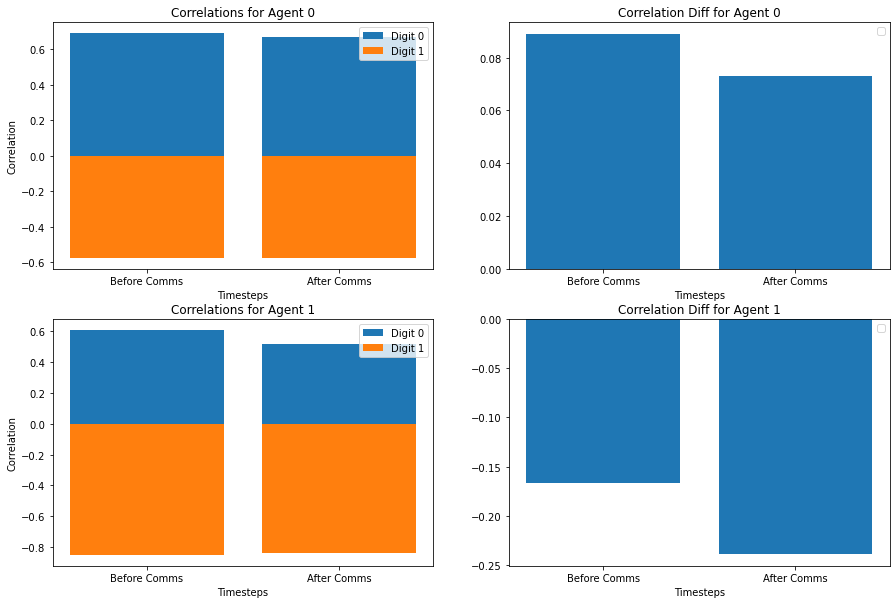

In [ ]:
corrs # target x agents x timesteps
fig, axs = plt.subplots(2, 2, figsize=(15, 10)) 
for ag, ag_axs in enumerate(axs) : 
    ag_corrs = corrs.mean(-1).mean(-1)[:, ag]
    for t in range(2) : 
        t_corrs = ag_corrs[t]
        ag_axs[0].bar(range(len(t_corrs)), (-1)**t * t_corrs, label= f'Digit {t}')

    diff_corrs = [diff_max(c) for c in ag_corrs.T]
    ag_axs[1].bar(range(len(diff_corrs)), diff_corrs)

    ag_axs[0].set_title(f'Correlations for Agent {ag}')
    for ax in ag_axs : 
        ax.set_xlabel("Timesteps")
        ax.set_xticks(range(len(t_corrs)))
        ax.set_xticklabels(['Before Comms', 'After Comms'])
        ax.legend()
    ag_axs[0].set_ylabel('Correlation')
    ag_axs[1].set_title(f'Correlation Diff for Agent {ag}')
    

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


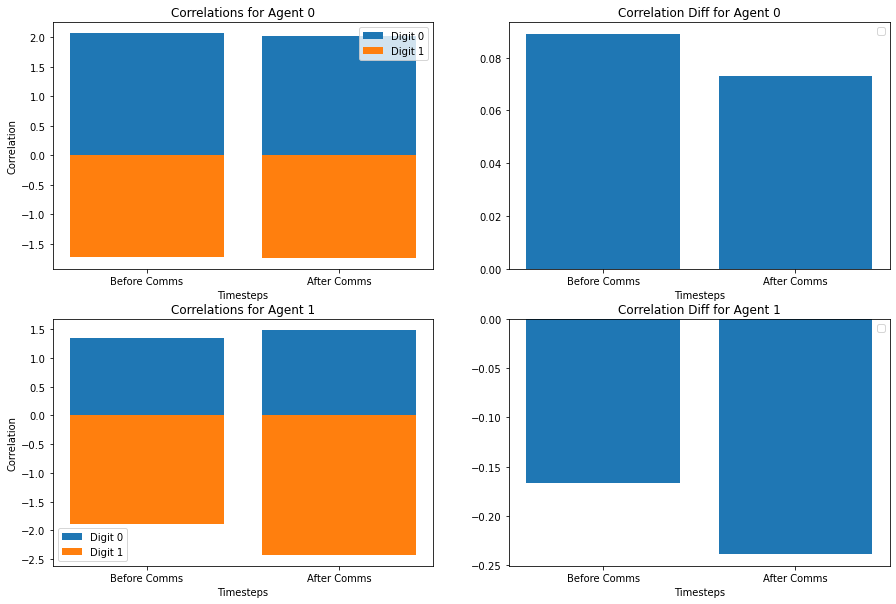

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(15, 10)) 
for ag, ag_axs in enumerate(axs) : 
    ag_corrs = corrs.mean(-1).mean(-1)[:, ag]
    for t in range(2) : 
        t_corrs =  ag_corrs[t] / base_corrs.mean(-1)[ag]
        ag_axs[0].bar(range(len(t_corrs)), (-1)**t * t_corrs, label= f'Digit {t}')

    diff_corrs = [diff_max(c) for c in ag_corrs.T]
    ag_axs[1].bar(range(len(diff_corrs)), diff_corrs)

    ag_axs[0].set_title(f'Correlations for Agent {ag}')
    for ax in ag_axs : 
        ax.set_xlabel("Timesteps")
        ax.set_xticks(range(len(t_corrs)))
        ax.set_xticklabels(['Before Comms', 'After Comms'])
        ax.legend()    
    ag_axs[0].set_ylabel('Correlation')
    ag_axs[0].legend()
    ag_axs[1].set_title(f'Correlation Diff for Agent {ag}')


### Bottleneck

In [17]:
from community.funcspec.bottleneck import readout_retrain
bottleneck_metrics = readout_retrain(community, loaders, n_classes, n_epochs=3, n_tests=1, use_tqdm=True, symbols=True, force_connections=False)

Bottleneck Metric Trials :   0%|          | 0/1 [00:00<?, ?it/s]

Train Epoch::   0%|          | 0/3 [00:00<?, ?it/s]

KeyboardInterrupt: 

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


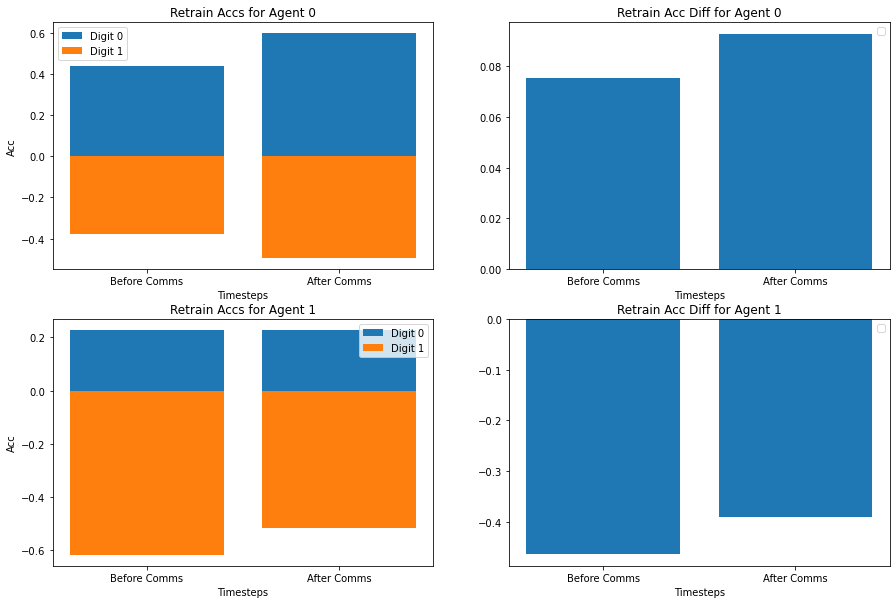

In [ ]:
all_accs = bottleneck_metrics['accs'][0] # target x timesteps x agents
fig, axs = plt.subplots(2, 2, figsize=(15, 10)) 
for ag, ag_axs in enumerate(axs) : 
    ag_accs = all_accs[..., ag]
    for t in range(2) : 
        t_accs =  ag_accs[t]
        ag_axs[0].bar(range(len(t_accs)), (-1)**t * t_accs, label= f'Digit {t}')

    diff_corrs = [diff_max(c) for c in ag_accs.T]
    ag_axs[1].bar(range(len(diff_corrs)), diff_corrs)

    ag_axs[0].set_title(f'Retrain Accs for Agent {ag}')
    ag_axs[0].set_ylabel('Acc')
    for ax in ag_axs : 
        ax.set_xlabel("Timesteps")
        ax.set_xticks(range(len(t_accs)))
        ax.set_xticklabels(['Before Comms', 'After Comms'])
        ax.legend()

    ag_axs[1].set_title(f'Retrain Acc Diff for Agent {ag}')


In [ ]:
bottleneck_metrics['accs'][0][..., 0]

array([[0.05188301, 0.04777644],
       [0.46754808, 0.99989984]])

In [ ]:
ag_accs[0]

array([0.04046474, 0.06720753])

### New Correlation 

In [ ]:
def get_input_variations(dataset, index) : 

    original_data, original_label = (d.clone() for d in dataset[index])

    scenarios = ['Original', 'Same_Count', '0s', '1s', 'Inv']
    labels = [[original_label], [original_label], [torch.tensor([n_classes-1, 0])], [torch.tensor([0, n_classes-1])], [original_label]]
    labels = [l * 10 for l in labels]

    data_var = {s : [] for s in scenarios}
    for l in labels[0] : 
        data_var['Original'].append(original_data)

    dataset.regenerate = True
    for i, (lab, s) in enumerate(zip(labels[1:], scenarios[1:])) : 

        def regen_data(l, s) : 
            dataset.data[1][index] = l
            return dataset.__getitem__(index, inv=('Inv' in s)) [0]

        for l in lab : 
            data_var[s].append(regen_data(l, s))

    dataset.regenerate = False
    dataset.data[1][index] = original_label
    return {s : torch.stack(d).cpu() for s, d in data_var.items()}, labels


In [ ]:
#Visualize data variations : 
datas, labels = get_input_variations(datasets[0], 5)
datas = {s : process_data(data, flatten=False) for s, data in datas.items()}
labels = torch.stack([l for lab in labels for l in lab[:2] if type(lab) is list])
create_gifs(torch.cat([d[:, :, :2, 0, ...] for d in datas.values()], 2), labels, 'symbols', data_config['input_size'], 'max_count')

In [ ]:
from scipy.stats import pearsonr
from community.funcspec.correlation import v_pearsonr, get_correlation, randperm_no_fixed

perm = lambda s : randperm_no_fixed(s.shape[1])

def vect_pearson_diff(h1, h2) : 
    # Returns vectorized pearson correlation for nonequal vectors
    mask = (h1 != h2).all(1)
    corrs = v_pearsonr(h1[mask], h2[mask])[0] if mask.sum() > 0 else v_pearsonr(h1, h2)[0]
    return corrs.mean()

def get_correlations(network, dataset, n_tests=32) : 

    corrs = []

    for i in trange(min(n_tests, len(dataset))) : 

        data_dict = get_input_variations(datasets[0], i)[0]
        data_dict = {s : [process_data(d, flatten=not use_conv, device=device)] for s, d in data_dict.items()}
        #split = int(max(np.floor(data_dict['Original'].shape[2] / batch_size), 1))
        #print(f'{data_dict["Original"].shape[2]} input to process, splitting in {split}  batches')
        #data_dict = {s : d.split(split, dim=2) for s, d in data_dict.items()}

        states = {s : np.concatenate([network(d)[1][-1].clone().cpu().data.numpy() for d in data], 1) for s, data in data_dict.items()}
        corrs.append(np.array([[[vect_pearson_diff(h1[i], h2[i]) for h1 in states.values()] for h2 in states.values()] for i in range(2)]))

    return np.stack(corrs), states


In [ ]:
corrs, states = get_correlations(community, datasets[0], 256)

  0%|          | 0/256 [00:00<?, ?it/s]

/home/gb21/.conda/envs/community/lib/python3.10/site-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


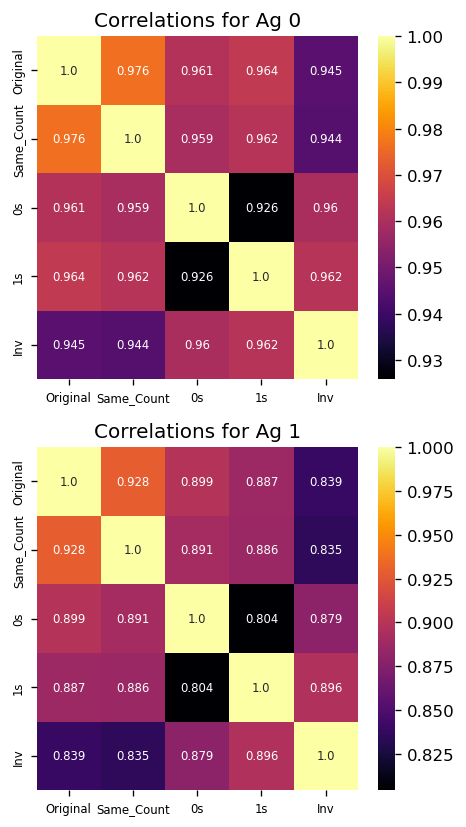

In [ ]:
fig, axs = plt.subplots(2, 1, figsize=(4, 7), dpi=120)
scenarios = list(states.keys())

for i, (ax, c) in enumerate(zip(axs, corrs.mean(0))) : 
    ax = sns.heatmap(c, cmap="inferno", annot=c.round(3).astype(str), annot_kws={'fontsize': 7}, fmt='s', ax=ax)
    ax.set_title(f'Correlations for Ag {i}')
    ax.set_xticks(np.arange(len(scenarios))+0.5)
    ax.set_xticklabels(scenarios, fontsize=7)
    ax.set_yticks(np.arange(len(scenarios))+0.5)
    ax.set_yticklabels(scenarios, fontsize=7)
    
#fig.colorbar(im)

fig.tight_layout()
fig.show()

In [ ]:
def get_same_count_data(dataset, idx) : 
    
    dataset.regenerate = True
    orig_data, orig_label = dataset[idx]
    sym_assigns = [dataset.symbol_assignments[l] for l in orig_label]
    #print(sym_assigns)

    same_count_datas = torch.stack([dataset.__getitem__(idx, symbol_assigns=[s1, s2])[0] for s1 in sym_assigns[0] for s2 in sym_assigns[1]])
    same_count_datas_0 = torch.stack([dataset.__getitem__(idx, symbol_assigns=[s1, None])[0] for s1 in sym_assigns[0]])
    same_count_datas_1 = torch.stack([dataset.__getitem__(idx, symbol_assigns=[None, s2])[0] for s2 in sym_assigns[1]])
    #same_count_datas = torch.stack([ torch.stack((d1[:, 0], d2[:, 1])) for d1 in same_count_datas_0 for d2 in same_count_datas_1])

    dataset.regenerate = False

    return same_count_datas, [same_count_datas_0, same_count_datas_1], orig_data

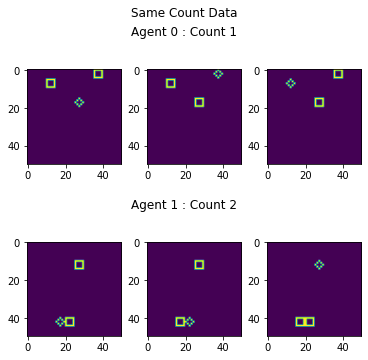

In [ ]:
idx = 10
dataset = datasets[0]
data, target = dataset[idx]
same_count_datas, same_count_datas_per_ag, original_data = get_same_count_data(dataset, idx)

fig = plt.figure(constrained_layout=True, figsize=(5, 5))
fig.suptitle('Same Count Data')

nrows, ncols = same_count_datas.shape[:2]

subfigs = fig.subfigures(nrows=2, ncols=1)

for ag, subfig in enumerate(subfigs) : 
    data = same_count_datas_per_ag[ag][:5]
    subfig.suptitle(f'Agent {ag} : Count {target[ag]}')
    axs = subfig.subplots(nrows=1, ncols=len(data), sharey=False)
    if len(data) == 1 : axs = np.array([axs])
    for p, ax in enumerate(axs.flatten()) : 
        ax.imshow(data[p, -1, ag])
        #ax.set_title(f'Agent {p}')


In [ ]:
same_count_states = [community(process_data(d, device=device))[1][-1].cpu().data.numpy() for d in same_count_datas_per_ag]
same_count_corrs = np.array([[pearsonr(h1, h2)[0] for h1 in states[ag] for h2 in states[ag]] for ag, states in enumerate(same_count_states)]).reshape(-1, 3, 3)


/home/gb21/.conda/envs/community/lib/python3.10/site-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


In [ ]:
same_count_states = community(process_data(same_count_datas, device=device))[1][-1].cpu().data.numpy()
same_count_corrs = np.array([[pearsonr(h1, h2)[0] for h1 in states for h2 in states] for ag, states in enumerate(same_count_states)]).reshape(-1, 9, 9)

In [ ]:
same_count_states.shape

(4, 9, 25)

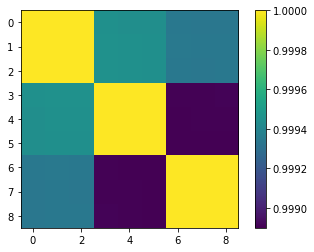

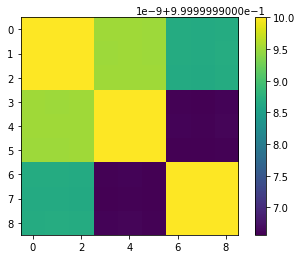

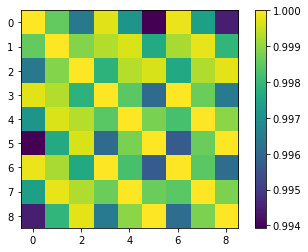

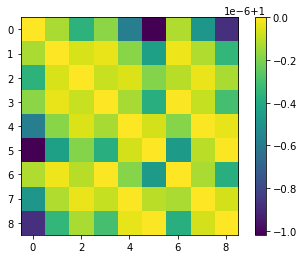

In [ ]:
for corr, data in zip(same_count_corrs, same_count_corrs) : 
    plt.figure()
    plt.imshow(corr)
    plt.colorbar()

In [ ]:
from community.funcspec.single_model_loop import compute_all_metrics
from community.funcspec.correlation import get_pearson_metrics, fixed_information_data

In [ ]:
idx = 8
dataset = datasets[0]
data, target = dataset[idx]
same_count_datas = fixed_information_data(data, target, 0)

fig = plt.figure(constrained_layout=True, figsize=(5, 5))
fig.suptitle('Same Count Data')

nrows, ncols = same_count_datas.shape[:2]

subfigs = fig.subfigures(nrows=2, ncols=1)

for ag, subfig in enumerate(subfigs) : 
    data = same_count_datas_per_ag[ag]
    subfig.suptitle(f'Agent {ag} : Count {target[ag]}')
    axs = subfig.subplots(nrows=1, ncols=len(data), sharey=False)
    if len(data) == 1 : axs = np.array([axs])
    for p, ax in enumerate(axs.flatten()) : 
        ax.imshow(data[p, -1, ag])
        #ax.set_title(f'Agent {p}')

fig.show()

IndexError: tuple index out of range

In [ ]:
data, target = next(iter(loaders[0]))
data = process_data(data, False)
same_count_datas = fixed_information_data(data, target, 1)


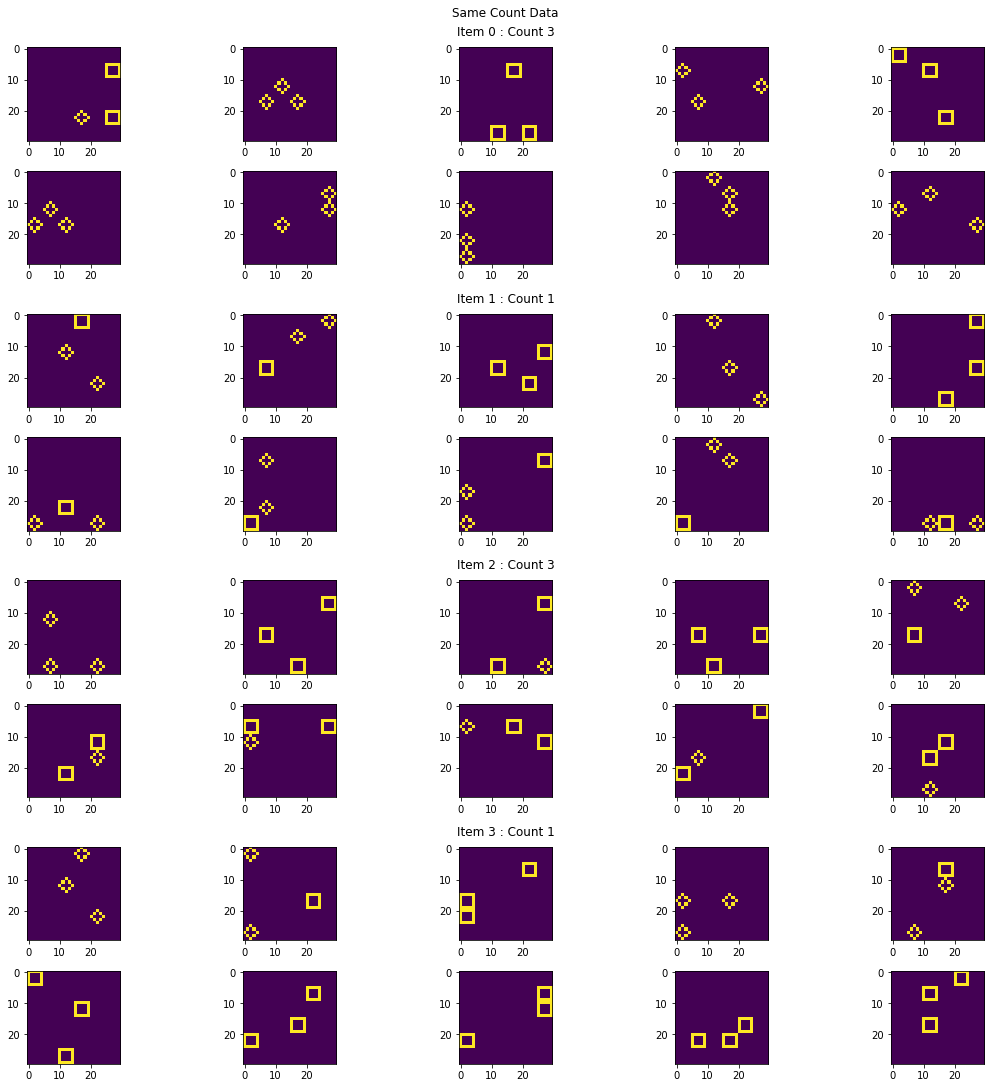

In [ ]:

fig = plt.figure(constrained_layout=True, figsize=(15, 15))
fig.suptitle('Same Count Data')

subfigs = fig.subfigures(nrows=len(same_count_datas), ncols=1)

for d, subfig in enumerate(subfigs) : 
    data = same_count_datas[d]
    subfig.suptitle(f'Item {d} : Count {target[d, 0]}')
    axs = subfig.subplots(nrows=2, ncols=5, sharey=False)
    if len(data) == 1 : axs = np.array([axs])
    for ag, ag_ax in enumerate(axs) : 
        for p, ax in enumerate(ag_ax.flatten()) : 
            ax.imshow(data[-1, ag, p, 0].cpu())
        #ax.set_title(f'Agent {p}')    
    